# Определение порядка водотоков

Для подготовки данных были произведены следующие действия:
* Перевод слоя полигональных объектов в линейные: ВЕКТОР - ОБРАБОТКА ГЕОМЕТРИИ - ПРЕОБРАЗОВАТЬ ПОЛИГОНЫ В ЛИНИИ (QGIS)
* Объединение линейных векторных слоев: ВЕКТОР - ГЕООБРАБОТКА - ОБЪЕДИНЕНИЕ (QGIS)
* Разбиение линий на сегменты: АНАЛИЗ - ВЕКТОРНЫЙ ОВЕРЛЕЙ - РАЗБИТЬ ЛИНИЯМИ (QGIS)
* Задание новых полей с индексами: PYTHON
* Извлечение вершин на пересечениях сегментов: ВЕКТОР - АНАЛИЗ - ПЕРЕСЕЧЕНИЯ ЛИНИЙ (QGIS)

В результате преобразований был получен следующий векторный слой: v_new.shp

In [14]:
# Загрузим все нужные библиотеки 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import time
import networkx as nx
import pandas as pd
import geopandas, geoplot

## Загрузка векторного слоя 

In [15]:
data = geopandas.read_file('/media/mikhail/Data/Ob/v_new.shp')
data.head(5)

,id,NEW,id_2,NEW_2,geometry
0,1,1,1,2,POINT (30.99791 59.93690)
1,1,1,2,5,POINT (30.99791 59.93690)
2,1,2,1,1,POINT (30.99791 59.93690)
3,1,2,1,3,POINT (30.75824 59.76402)
4,1,2,2,5,POINT (30.99791 59.93689)


## Формирование графа

На данном этапе данные можно описать следующим образом. Точки находятся на пересечениях сегментов. Все сегменты рек проиндексированы в поле NEW, все реки (которые состоят из нескольких сегментов) проиндексированы с помощью значений поля id. В результате определения точек пересечния сегментов, таблица атрибутов была преобразована. Были сформированы поля id_2 и NEW_2 - то есть точка характеризуется двуям парами полей: "id" и "NEW". Рассмотрим пару полей NEW и NEW_2, так как в дальнейшем будем использовать именно их. Каждая строка - это точка пересчения сегментов, в таком случае сегмент реки NEW через данную точку имеет пересечение с NEW_2. 

Таким образом, если рассматривать сегменты реки как вершины, а их связи/пересечения как ребра, то таблицу, составленную из полей NEW и NEW2 можно воспринимать как список смежности.

In [16]:
list_of_adjacencies = data[['NEW', 'NEW_2']]
list_of_adjacencies = np.array(list_of_adjacencies)

# Функция для приведения списка смежности к нужному формату
def prepare(list_of_adjacencies):
    lines = []
    for i in list_of_adjacencies:
        i_0 = str(i[0])
        i_1 = str(i[1])
        string = i_0 + ' ' + i_1
        lines.append(string)
    return(lines)

lines = prepare(list_of_adjacencies)
G = nx.parse_adjlist(lines, nodetype = int)
print('Было: \n', list_of_adjacencies[0:2], '\n')
print('Стало: \n', lines[0:2], '\n')
# Посмотрим, корректно ли мы опередили граф
print('Список всех вершин (сегментов реки):', G.nodes())

Было: 
 [[1 2]
 [1 5]] 

Стало: 
 ['1 2', '1 5'] 

Список всех вершин (сегментов реки): [1, 2, 5, 3, 6, 4, 7]


Визуализируем граф

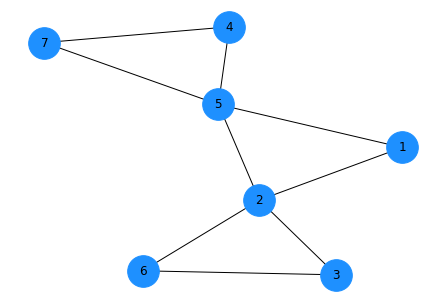

In [17]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, node_color='#1E90FF', node_size=1000) 

Стоит обратить внимание, что граф, составленный по гидрологической сети таким образом содержит много циклов.

Основные этапы обработки можно описать в виде схемы:
![Flow.png](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/flow.png)

Первые этапы выполнялись над векторным слоем водотоков в геоинформационной системе QGIS. Алгоритм обхода графа осуществлялся с помощью скриптов на Python.

## Алгоритм присваивания вершинам (сегментам реки) их порядка в речной сети

Мы предполагаем, что нам известно, какой сегмент в речной сети является замыкающим (устье реки). Поэтому присваивание атрибутов будет происходить, начниая именно с него. В данном примере номер сегмена, с которого мы будем начинать обход графа - 1.

Код ниже присваивает замыкающему сегменту ранг 1, всем сегментам, впадающим в замыкающий - ранг 2, все сегменты, впадающие в притоки второго ранга - ранг 3 и т.д.

### 1. Присваивание ранга кажому сегменту (атрибут 'rank')

In [18]:
# Количество вершин в графе
nodes_amount = len(G.nodes())
print('Количество вершин в графе -', nodes_amount)

# Функция для присваивания атрибутов вершинам графа
def attr_set(G, start):
    # Начальной вершине присвоим значением атрибута - 1
    attrs = {start: {'rank' : 1}}
    nx.set_node_attributes(G, attrs)
    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        # Добавление атрибута - количество потомков у данной вершины
        n_offspring = len(neighbors)
        attrs = {vertex: {'offspring' : n_offspring}}
        nx.set_node_attributes(G, attrs)
        
        # Значение атрибута в рассматриваемой вершине
        att = G.nodes[vertex].get('rank')
        if att != None:
            # Значение атрибута, которое будет присвоено соседним вершинам
            att_number = att + 1
        
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            attrs = {i: {'rank' : att_number}}
            nx.set_node_attributes(G, attrs)
    
    # Проверка, правильно ли мы все сделали
    for vertex in list(G.nodes()):
        # Если граф неполносвязный, то удаляем те элементы, до которых мы не можем добраться
        if G.nodes[vertex].get('rank') == None:
            G.remove_node(vertex)
        else:
            print(vertex, ' - ', G.nodes[vertex])

attr_set(G, 1)

Количество вершин в графе - 7
1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2}
5  -  {'rank': 2, 'offspring': 2}
3  -  {'rank': 3}
6  -  {'rank': 3}
4  -  {'rank': 3}
7  -  {'rank': 3}


## Основной алгоритм - присваивание порядка водотоков 

Всем вершинам, у которых нет потомков, присваивается значение 1. Всем вершинам, которые имеют в качестве потомков вершины с 1 - присваивается значение равное количеству потомков с этими единицами.

### 2. Определение порядка водотоков (атрибут 'value')

In [19]:
# Функция для определения порядка сегментов реки по аналогии с методом Шреве
def set_values(G, start):    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        att_rank = G.nodes[vertex].get('rank')
        att_offspring = G.nodes[vertex].get('offspring')
        
        # Для замыкающего сегмента производим следующую процедуру:
        if att_rank == 1:
            # Определяем потомков
            offspring = list(nx.bfs_successors(G, source = vertex)) 
            # Используем только ближайших к данной вершине соседей (прямых потомков)
            offspring = offspring[0][1]
            
            # Записываем в список значения атрибутов value у всех потомков
            last_values = []
            for child in offspring:
                if G.nodes[child].get('value') != None:
                    last_values.append(G.nodes[child].get('value'))
                else:
                    last_values.append(0)
                    
            last_values = np.array(last_values)
            sum_values = np.sum(last_values)
            
            # Если сумма не равна 0, то атрибут присваивается
            if sum_values != 0:
                attrs = {vertex: {'value' : sum_values}}
                nx.set_node_attributes(G, attrs)
            # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
            else:
                pass
            
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            # Значение атрибутов в рассматриваемой вершине
            att_rank = G.nodes[i].get('rank')
            att_offspring = G.nodes[i].get('offspring')
            
            # Если у вершины на предыдущем этапе не было найдено потомков, то ей присваивается значение 1
            if att_offspring == None:
                attrs = {i: {'value' : 1}}
                nx.set_node_attributes(G, attrs)            
            # Если вершина имеет потомков, то необходимо определить значения атрибута "value" в них
            else:
                # Производим поиск всех потомков
                offspring = list(nx.bfs_successors(G, source = i)) 
                # Используем только ближайших к данной вершине соседей (прямых потомков)
                offspring = offspring[0][1]

                # Цикл определения значений в вершинах - потомках
                last_values = []
                for child in offspring:
                    # Нужны только те потомки, значение ранга которых строго больше, чем у рассматриваемой вершины
                    if G.nodes[child].get('rank') > att_rank:
                        if G.nodes[child].get('value') != None:
                            last_values.append(G.nodes[child].get('value'))
                        else:
                            pass
                    else:
                        pass
                    
                last_values = np.array(last_values)
                sum_values = np.sum(last_values)
                
                # Если сумма не равна 0, то атрибут присваивается
                if sum_values != 0:
                    attrs = {i: {'value' : sum_values}}
                    nx.set_node_attributes(G, attrs)
                # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
                else:
                    pass          
                
    # Проверка, правильно ли мы все сделали
    for vertex in list(G.nodes()):
        print(vertex, ' - ', G.nodes[vertex])
    print('\n')

# Поскольку мы начинаем обход графа из стартовой точки, то нам необходимо производить несколько итераций последовательно
# Функция для итеративного обхода
def iter_sets(G, start):
    # Определяем максимальное значение ранга в данном графе
    ranks = []
    for vertex in list(G.nodes()):
        ranks.append(G.nodes[vertex].get('rank'))
    max_rank = max(ranks) 
    
    # Мы должны проитерировать ровно столько раз, сколько рангов есть в графе
    for iteration in range(0, max_rank):
        set_values(G, start)

# Применение алгоритма: запускаем функцию iter_sets
iter_sets(G, 1)

1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2}
5  -  {'rank': 2, 'offspring': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}


1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2, 'value': 2}
5  -  {'rank': 2, 'offspring': 2, 'value': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}


1  -  {'rank': 1, 'offspring': 2, 'value': 4}
2  -  {'rank': 2, 'offspring': 2, 'value': 2}
5  -  {'rank': 2, 'offspring': 2, 'value': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}




Таким образом обход графа производится в 2 этапа:

1) Присваивание вершинам графа атрибута 'rank', где значение ранга равно 1 для замыкающего сегмента, 2 - для всех его притоков, 3 - для всех притоков 2го ранга и т.д. Также вершинам присваивается атрибут 'offspring' - количество прямых потомков у данной вершины (значение ранга потомков всегда на 1 больше, чем у рассматриваемой вершины)

2) Присваивание вершинам графа атрибута 'value' на основе количества потомков у вершин и их ранга. При этом, отсутствие прямых потомков у вершины свидетельствует о том, что данный сегмент не имеет притоков и должен получить значение 'value' - 1. 

Визуализация процесса работы алгоритма:

![animation_graph.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph.gif)

## Заполнение атрибутивной таблицы для векторного слоя

Мы построили и обошли граф, теперь необходимо сохранить результаты.

In [38]:
# Составляем датасет, где каждая вершина - строка
def make_dataframe(G):    
    dataframe = []
    for vertex in list(G.nodes()):
        rank = G.nodes[vertex].get('rank')
        value = G.nodes[vertex].get('value')
        dataframe.append([vertex, rank, value])

    dataframe = pd.DataFrame(dataframe, columns = ['NEW', 'Rank', 'Value'])
    return(dataframe)
    
dataframe = make_dataframe(G)

In [39]:
# Загружаем исходный слой с реками
rivers = geopandas.read_file('/media/mikhail/Data/Ob/r_new.shp')

# Объединяем датасеты
data_merged = pd.merge(rivers, dataframe, on = 'NEW')
# Сохраняем в файл
data_merged.to_file("/media/mikhail/Data/Ob/r_new_with_att.shp")

data_merged

,id,NEW,geometry,Rank,Value
0,1,1,"LINESTRING (31.03324 59.95152, 30.99833 59.937...",1,4
1,1,2,"LINESTRING (30.99791 59.93690, 30.98531 59.916...",2,2
2,1,3,"LINESTRING (30.75824 59.76402, 30.74834 59.770...",3,1
3,2,4,"LINESTRING (30.85074 59.95570, 30.85673 59.95648)",3,1
4,2,5,"LINESTRING (30.85667 59.95647, 30.85667 59.956...",2,2
5,3,6,"LINESTRING (30.75755 59.73085, 30.75700 59.732...",3,1
6,4,7,"LINESTRING (30.86031 59.96864, 30.86025 59.968...",3,1
